In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from fytok.Tokamak import Tokamak
from fytok.utils.load_scenario import load_scenario
from fytok.utils.plot_profiles import plot_profiles, sp_figure
import scipy.constants
from spdm.data.Expression import Variable
from spdm.data.File import File
from spdm.utils.logger import logger
import freegs


2023-06-19 21:04:12,913 INFO [spdm] : Set mapping path: /home/salmon/workspace/fytok/python/fytok/_mapping


2023-06-19 21:07:33,836 INFO [spdm] : Load scenario/profiles from /home/salmon/workspace/data/15MA inductive - burn/15MA Inductive at burn-ASTRA.xls


2023-06-19 21:07:33,959 DEBUG [spdm] /home/salmon/workspace/SpDB/python/spdm/plugins/data/PluginGEQdsk.py:329:__init__: Open File URITuple(protocol='local', authority='', path=PosixPath('/home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt'), query=None, fragment='', format='', schema='') mode=Mode.read
2023-06-19 21:07:33,990 INFO [spdm] : Load scenario/equilibrium from /home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt
2023-06-19 21:07:34,036 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-19 21:07:34,040 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5


/home/salmon/.local/lib/python3.10/site-packages/IPython/core/formatters.py:367: FormatterWarning: text/html formatter returned invalid type <class 'matplotlib.figure.Figure'> (expected <class 'str'>) for object: <fytok.Tokamak.Tokamak object at 0x7f67941cc2e0>
  warnings.warn(


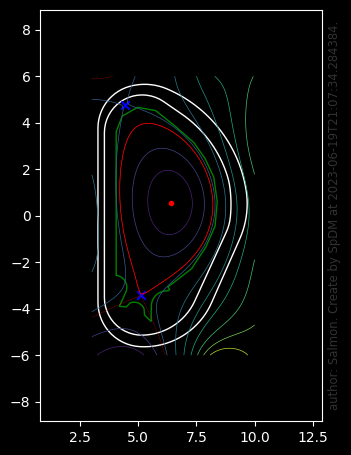

In [ ]:
scenario = load_scenario("/home/salmon/workspace/data/15MA inductive - burn")
tok = Tokamak("ITER",
              name=scenario["name"],
              description=scenario["description"],
              core_profiles={**scenario["core_profiles"],
                             #  "$default_value": {
                             #      "profiles_1d": {"grid": {
                             #          "rho_tor_norm": np.linspace(0, 1.0, 100),
                             #          "psi": np.linspace(0, 1.0, 100),
                             #          "psi_magnetic_axis": 0.0,
                             #          "psi_boundary": 1.0,
                             #      }}}
                             },
              equilibrium={**scenario["equilibrium"],
                           "code": {"name":  "freegs", "parameters": {"boundary": "fixed"}},
                           "$default_value": {"time_slice": {
                               "boundary": {"psi_norm": 0.99},
                               "coordinate_system": {"grid": {"dim1": 256, "dim2": 128}}
                           }}}
              )
display(tok)

In [ ]:
tok.equilibrium.time_slice

2023-06-19 21:07:46,430 INFO [spdm] : Update Equilibrium: EquilibriumFreeGS
2023-06-19 21:07:46,458 INFO [spdm] : Setup machine description: wall={'name': 'ITER', 'index': 1, 'description': 'for equilibrium codes (single closed limiter and vessel);'}
2023-06-19 21:07:46,460 DEBUG [spdm] /home/salmon/workspace/fytok_modules/python/fytok/plugins/equilibrium/freegs.py:95:_setup_equilibrium: (3.0, 10.0, -5.99, 6.01)
2023-06-19 21:07:46,461 INFO [spdm] : Using fixed boundary
2023-06-19 21:07:51,302 INFO [spdm] : Create Profile: Specified profile functions p'(psi), ff'(psi)
2023-06-19 21:07:51,306 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-19 21:07:51,308 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5
2023-06-19 21:07:51,417 INFO [spdm] : Using fixed lcfs
2023-06-19 21:07:51,419 INFO [spdm] : Using xpoints: [(5.106664972154215, -3.417

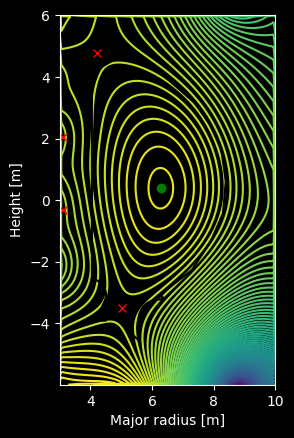

psi_relchange: 0.9999954008077003
bndry_relchange: 1.0
bndry_change: 0.5728017623142869


psi_relchange: 0.04121707008492616
bndry_relchange: 0.9999802840270743
bndry_change: 29052.102634181745


psi_relchange: 0.05004445364648172
bndry_relchange: 58.03060849880573
bndry_change: -28560.512536479255


psi_relchange: 0.04551123454363616
bndry_relchange: 0.5944844407561846
bndry_change: 721.509148982771


psi_relchange: 0.042648876396772444
bndry_relchange: 1.036252291090378
bndry_change: -34692.1643573022


psi_relchange: 0.04459741749872969
bndry_relchange: 10.024192968936694
bndry_change: 37188.352284599285


psi_relchange: 0.03914061424328249
bndry_relchange: 1.0721390438443998
bndry_change: -55136.37990227208


psi_relchange: 0.043453296176711134
bndry_relchange: 10.281885100685367
bndry_change: 56967.045301349186


psi_relchange: 0.037091509564712265
bndry_relchange: 1.0949611717874301
bndry_change: -63885.69183110979


psi_relchange: 0.043458703790632255
bndry_relchange: 10.3289367

KeyboardInterrupt: 

In [5]:
eq = tok.equilibrium.update(
    core_profiles_1d=tok.core_profiles.profiles_1d.current,
    lcfs=True,
    xpoints=True,
    wall=tok.wall,
    pf_active=tok.pf_active,
    Ip=1.5e6, beta_p=0.6056,
    tolerance=1.0e-2,)


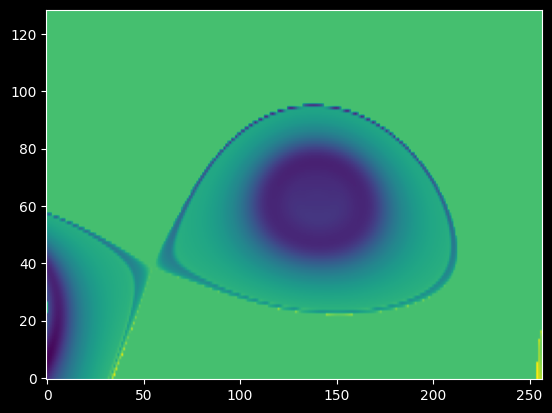

In [7]:
j_tor=tok.equilibrium.time_slice.current.profiles_2d[0].j_tor.__array__()       
plt.imshow(j_tor, origin="lower", aspect="auto")